# Install needed deps

#### Don't forget to run ```apt-get update --fix-missing && sudo apt-get install build-essential``` and ```apt-get install zlib1g-dev``` in case you are running on an Ubuntu image

In [50]:
%pip install pandas-ta==0.3.14b --pre
%pip install gym==0.21.0
%pip install ipywidgets
%pip install stable-baselines3[extra]
%pip install ta
%pip install quantstats
%pip install sklearn
%pip install feature_engine

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 631 kB 2.8 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708398 sha256=151011eff26ac09b9c83a4edf00c664ab06e2da3cbda625479b09b5527819667
  Stored in directory: /home/alexandrustefan/.cache/pip/wheels/4d/6e/7d/0e050cb65b427dd0db5c5ab2c9a1f1ffa3d58db2f4db516268
Successfully built gym
ERROR: stable-baselines3 1.5.0 has requirement gym==0.21, but you'll have gym 0.22.0 which is incompatible.
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Processing /home/alexandrustefan/.cache/pip/wheels/27/6d/b3/a3a6e

# Prepare and fetch the data

In [2]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [3]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.800000,8793.000000,8714.900000,8739.000000,8988053
1,2018-05-15 07:00 AM,8739.000000,8754.800000,8719.300000,8743.000000,2288904
2,2018-05-15 08:00 AM,8743.000000,8743.100000,8653.200000,8723.700000,8891773
3,2018-05-15 09:00 AM,8723.700000,8737.800000,8701.200000,8708.100000,2054868
4,2018-05-15 10:00 AM,8708.100000,8855.700000,8695.800000,8784.400000,17309722
...,...,...,...,...,...,...
34234,2022-04-10 09:00 PM,43128.000000,43223.000000,42626.000000,42722.000000,17469719
34235,2022-04-10 10:00 PM,42711.000000,42745.693560,41933.000000,42170.000000,19196439
34236,2022-04-10 11:00 PM,42147.547378,42433.000000,42031.000000,42177.515051,7187135
34237,2022-04-11 12:00 AM,42181.000000,42404.000000,41824.000000,42328.000000,16677839


## Create features for the feed module

In [4]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies_without_backfilling(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    #This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_9': ta1.trend.ema_indicator(data['Close'], window=9, fillna=True),
        'ema_21': ta1.trend.ema_indicator(data['Close'], window=21, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
        'macd_wolfpack': macd(data['Close'], fast=3, slow=8, signal=9),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies_without_backfilling(data, fill_value=None)
    return data

In [5]:
data = generate_features(data)
# remove not needed features
to_drop = ['others_dlr', 'compsum']
data = data.drop(columns=to_drop)
data.shape

/home/alexandrustefan/Projects/rl-algos/.venv/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/home/alexandrustefan/Projects/rl-algos/.venv/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/home/alexandrustefan/Projects/rl-algos/.venv/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/home/alexandrustefan/Projects/rl-algos/.venv/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


(34039, 140)

## Remove features with low variance before splitting the dataset

In [6]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,rsi_26,macd_normal,macd_short,macd_long,macd_wolfpack,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
0,2018-05-23 02:00 PM,7897.300000,7898.800000,7849.800000,7877.400000,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,65.542059,11.190548,10.871904,31.873058,19.596642,10.000000,-0.811487,-1.144302,0.072620,-0.103251
1,2018-05-23 03:00 PM,7877.400000,7889.700000,7661.000000,7700.000000,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,72.698849,1.333779,-5.426751,34.355233,-24.639480,1.666667,-1.248391,-1.633909,0.079103,-0.123446
2,2018-05-23 04:00 PM,7700.000000,7700.100000,7548.100000,7605.400000,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,75.527202,-10.060459,-21.497215,37.504922,-51.837145,1.666667,-1.612964,-2.069373,0.080681,-0.134215
3,2018-05-23 05:00 PM,7605.400000,7623.600000,7441.800000,7511.100000,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,77.907846,-21.778972,-36.146245,41.269618,-66.773623,1.666667,-1.797159,-2.272346,0.082309,-0.144950
4,2018-05-23 06:00 PM,7511.100000,7551.600000,7403.000000,7489.100000,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,78.418914,-28.422775,-41.976877,44.917996,-57.191729,1.666667,-1.879146,-2.372706,0.082361,-0.147455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34034,2022-04-10 09:00 PM,43128.000000,43223.000000,42626.000000,42722.000000,17469719,1.037130e+10,-4104265104,-0.401360,-1.382506e+08,...,51.900797,29.174165,26.063864,39.192077,-88.886973,58.333333,-1.976780,-2.627052,0.068806,-0.377239
34035,2022-04-10 10:00 PM,42711.000000,42745.693560,41933.000000,42170.000000,19196439,1.036330e+10,-4123461543,-0.409699,-1.632277e+09,...,59.766119,-28.754298,-55.805732,41.060960,-238.976161,1.666667,-2.371675,-3.058553,0.070805,-0.385286
34036,2022-04-10 11:00 PM,42147.547378,42433.000000,42031.000000,42177.515051,7187135,1.036135e+10,-4116274408,-0.398681,-1.391378e+09,...,59.627602,-63.620477,-93.848434,42.544798,-235.302371,3.333333,-2.397237,-3.090137,0.070774,-0.385176
34037,2022-04-11 12:00 AM,42181.000000,42404.000000,41824.000000,42328.000000,16677839,1.037366e+10,-4099596569,-0.263424,-8.340725e+08,...,56.873369,-72.934912,-92.214748,42.314030,-147.566758,11.666667,-2.246279,-2.907667,0.071017,-0.382983


# Setup which data to use for training and which data to use for evaluation of RL Model

In [7]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [8]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

## Implement basic feature engineering

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [10]:
from scipy.stats import iqr


def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0



rf = RandomForestClassifier(n_estimators=100, 
                            random_state=1990, 
                            n_jobs=-1)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.65)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))

SelectBySingleFeaturePerformance(cv=5,
                                 estimator=RandomForestClassifier(n_jobs=-1,
                                                                  random_state=1990),
                                 threshold=0.65)

In [11]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)

In [12]:
# import matplotlib.pyplot as plt

# feature_performance.plot.bar(figsize=(40, 10))
# plt.title('Performance of ML models trained with individual features')
# plt.ylabel('roc-auc')

In [13]:
features_to_drop = sel.features_to_drop_
# features_to_drop

In [14]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

124

In [15]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

((11403, 16), (11403, 16), (11233, 16))

In [16]:
X_train.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'volume_em',
 'volume_vpt',
 'volatility_kchi',
 'trend_aroon_up',
 'momentum_stoch_rsi',
 'others_dr',
 'lr_high',
 'lr_close',
 'r_volume',
 'macd_wolfpack']

## Normalize the dataset subsets to make the model converge faster

In [17]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [18]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

## Look at training data

In [19]:
X_train_scaled

,date,open,high,low,close,volume,volume_em,volume_vpt,volatility_kchi,trend_aroon_up,momentum_stoch_rsi,others_dr,lr_high,lr_close,r_volume,macd_wolfpack
0,2018-05-23 02:00 PM,0.190400,0.186091,0.190045,0.189596,0.062853,0.002843,0.542012,0.0,0.041667,0.866068,0.458402,0.460018,0.504665,0.581720,0.604470
1,2018-05-23 03:00 PM,0.189588,0.185727,0.182304,0.182359,0.159323,0.002813,0.530737,0.0,0.000000,0.283937,0.404570,0.472016,0.450068,0.508756,0.530585
2,2018-05-23 04:00 PM,0.182351,0.178142,0.177674,0.178500,0.283565,0.002828,0.520131,0.0,0.000000,0.000000,0.432117,0.387603,0.478144,0.547114,0.485158
3,2018-05-23 05:00 PM,0.178492,0.175082,0.173315,0.174653,0.260466,0.002833,0.521274,0.0,0.041667,0.000000,0.431811,0.439843,0.477835,0.547253,0.460210
4,2018-05-23 06:00 PM,0.174646,0.172201,0.171724,0.173755,0.155062,0.002836,0.530937,0.0,0.000000,0.000000,0.457301,0.441648,0.503559,0.580747,0.476214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11398,2019-09-10 01:00 PM,0.287107,0.280911,0.287648,0.286425,0.004277,0.002816,0.542659,0.0,0.041667,0.093477,0.460728,0.471961,0.506999,0.583063,0.569764
11399,2019-09-10 02:00 PM,0.286414,0.280191,0.285638,0.285161,0.016059,0.002811,0.542508,0.0,0.000000,0.000000,0.457045,0.469825,0.503302,0.576577,0.559195
11400,2019-09-10 03:00 PM,0.285149,0.279351,0.285597,0.283857,0.012838,0.002838,0.542402,0.0,0.375000,0.000000,0.456770,0.468745,0.503026,0.576137,0.548588
11401,2019-09-10 04:00 PM,0.283846,0.280311,0.285720,0.286058,0.005197,0.002898,0.542645,0.0,0.333333,0.684403,0.479438,0.484752,0.525702,0.615932,0.572606


# Defining the environment

In [83]:
import random
import gym
from gym import spaces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# infinite number in python
MAX_NET_WORTH = 2147483647
MAX_NUM_QUOTE_OR_BASE_ASSET = 2147483647

INITIAL_QUOTE_ASSET = 10000
INITIAL_BASE_ASSET = 0
OBSERVATION_WINDOW_SIZE = 24 # Probably we should put it as param ?

class SimpleTradingEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}

    def __init__(self, df, trading_fee):
        
        self.df = df
        self.window_size = OBSERVATION_WINDOW_SIZE
        self.prices, self.features = self._process_data(df)
        # The shape of the observation is (window_size * features + environment_features) the environment_features are: quote_asset, base_asset, net_worth. The entire observation is flattened in a 1D np array. 
        self.obs_shape = ((OBSERVATION_WINDOW_SIZE * self.features.shape[1] + 3),)

        print(self.obs_shape)

        # Action space
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3.0, 1.0]), dtype=np.float32)
        # Observation space
        self.observation_space = spaces.Box(low=-1, high = 1, shape=self.obs_shape, dtype=np.float32)

        # Initialize the episode environment

        self._start_candle = OBSERVATION_WINDOW_SIZE # We assume that the first observation is not the first row of the dataframe, in order to avoid the case where there are no calculated indicators.
        self._end_candle = len(self.features) - 1
        self._trading_fee = trading_fee

        self._quote_asset = None
        self._base_asset = None
        self._done = None
        self._current_candle = None
        self._net_worth = None
        self._previous_net_worth = None

        # Render and analysis data
        self._action_history = None
        self._total_reward_accumulated = None
        self.trade_history = None # will be a dict
        self._first_rendering = None
        self._last_action_type = None
        

    def reset(self):
        self._done = False
        self._current_candle = self._start_candle
        self._quote_asset = INITIAL_QUOTE_ASSET
        self._base_asset = INITIAL_BASE_ASSET 
        self._net_worth = INITIAL_QUOTE_ASSET # at the begining our net worth is the initial quote asset
        self._previous_net_worth = INITIAL_QUOTE_ASSET # at the begining our previous net worth is the initial quote asset
        self._action_history = []
        self._total_reward_accumulated = 0.
        self._first_rendering = True
        self._last_action_type = 'Buy'
        self.trade_history = {}
        return self._get_observation()

    def _take_action(self, action):
        self._done = False
        self._current_candle += 1
        current_price = random.uniform(
            self.df.loc[self._current_candle, "low"], self.df.loc[self._current_candle, "high"])

        if self._current_candle == self._end_candle:
            self._done = True

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy % assets
            # Determine the maximum amount of quote asset that can be bought
            available_amount_to_buy_with = int(self._quote_asset / current_price)
            # Buy only the amount that agent chose
            assets_bought = int(available_amount_to_buy_with * amount)
            # Update the quote asset
            self._quote_asset -= assets_bought * current_price
            # Update the base asset
            self._base_asset += assets_bought
            # substract trading fee from base asset based on the amount bought
            self._base_asset -= self._trading_fee * assets_bought
        

        elif action_type < 2:
            # Sell % assets
            # Determine the amount of base asset that can be sold
            amount_to_sell = int(self._base_asset * amount)
            received_quote_asset = amount_to_sell * current_price
            # Update the quote asset
            self._quote_asset += received_quote_asset
            # Update the base asset
            self._base_asset -= amount_to_sell
            
            # substract trading fee from quote asset based on the amount sold
            self._quote_asset -= self._trading_fee * received_quote_asset

        # Update the current net worth
        self._net_worth = self._base_asset * current_price + self._quote_asset

        # Add action to action history array as tuple
        self._action_history.append(self._generate_action_data_tuple(action, current_price))
        self._last_action_type = self._get_human_readable_action(action)



    def step(self, action):
        """
        Returns the next observation, reward, done and info.
        """
        self._current_candle += 1
        self._take_action(action)

        # Calculate reward comparing the current net worth with the previous net worth
        reward = self._net_worth - self._previous_net_worth

        self._total_reward_accumulated += reward

        # Update the previous net worth to be the current net worth after the reward has been applied
        self._previous_net_worth = self._net_worth

        obs = self._get_observation()
        # Update the info and add it to history data
        info = dict (
            total_reward_accumulated = self._total_reward_accumulated,
            net_worth = self._net_worth,
            action_type = self._get_human_readable_action(action),
            action_amount = action[1],
        )

        self._update_trade_history(info)


        return obs, reward, self._done, info


    def _get_observation(self):
        """
        Returns the current observation.
        """
        data_frame = self.features[(self._current_candle - self.window_size):self._current_candle]
        data_frame = data_frame.flatten()


        obs = np.append(data_frame, np.array([self._net_worth / MAX_NET_WORTH , self._quote_asset / MAX_NUM_QUOTE_OR_BASE_ASSET, self._base_asset / MAX_NUM_QUOTE_OR_BASE_ASSET], dtype=np.float32))

        return obs

    def _update_trade_history(self, info):
        if not self.trade_history:
            self.trade_history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.trade_history[key].append(value)


    def render(self, mode='human', close=False):
        """
        Renders a plot with trades made by the agent.
        """
        # action_types, action_amounts, _ = zip(*self._action_history)

        # def _plot_actions(action, candle):
        #     color = None
        #     if action == 'Sell':
        #         color = 'red'
        #     elif action == 'Buy':
        #         color = 'green'
        #     if color:
        #         plt.scatter(candle, self.prices[candle], color=color)

        # if self._first_rendering:
        #     self._first_rendering = False
        #     plt.cla()
        #     # Plot the prices
        #     plt.plot(self.prices)
            
        #     start_action = action_types[0]

        #     _plot_actions(start_action, self._start_candle)

        # _plot_actions(self._last_action_type, self._current_candle)

        # plt.suptitle(
        #     "Accumulated Reward: %.6f" % self._total_reward_accumulated + ' ~ ' +
        #     "Net Worth: %.6f" % self._net_worth +
        #     "Quote asset:  " + str(self._quote_asset) +
        #     "Base asset:  " + str(self._base_asset)
        # )

        # plt.pause(0.01)
        
        
        print(f'Accumulated Reward: {self._total_reward_accumulated} ---- Net Worth: {self._net_worth}')
        print(f'Quote asset: {self._quote_asset} ---- Base asset: {self._base_asset}')
        print(f'Last Action: {self._last_action_type} in percent of assets: {self._action_history[-1][1]} at price: {self._action_history[-1][2]}')
        print(f'--------------------------------------------------------------------------------------')

    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._action_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._action_history[i] == 'Sell':
                short_ticks.append(tick)
            elif self._action_history[i] == 'Buy':
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward_accumulated + ' ~ ' +
            "Total Profit: %.6f" % self._net_worth + ' ~~~~ ' +
            "Quote asset:  " + str(self._quote_asset) + ' ~ ' +
            "Base asset:  " + str(self._base_asset)
        )            

    def _process_data(self, df):
        """
        Processes the dataframe into features.
        """

        prices = self.df.loc[:, 'close'].to_numpy(dtype=np.float32)

        data_frame = df.iloc[:, 1:] # drop first column which is date TODO: Should be fixed outside of this class

        # Convert df to numpy array
        return prices, data_frame.to_numpy(dtype=np.float32)

    def _generate_action_data_tuple(self, action, price):
        """
        Returns the action type and amount as tuple
        """

        action_type_name = self._get_human_readable_action(action)

        amount = action[1]
        return (action_type_name, amount, price)

    def _get_human_readable_action(self, action):
        # if action is lower than 1 than it's buy action, if action is lower than 2 than it's sell action otherwise it's hold action
        action_type_name = None
        if action[0] < 1:
            action_type_name = 'Buy'
        elif action[0] < 2:
            action_type_name = 'Sell'
        else:
            action_type_name = 'Hold'
        
        return action_type_name    

### Initialize and validate the environment and run a random test of x steps

In [85]:
import os
import time
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

trading_fee = 0.0075
env = Monitor(SimpleTradingEnv(X_train_scaled, trading_fee))

check_env(env)

obs = env.reset()
for i in range(10):
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        break
env.close

(363,)
Accumulated Reward: 0.0 ---- Net Worth: 10000.0
Quote asset: 10000.0 ---- Base asset: 0
Last Action: Sell in percent of assets: 0.15751788020133972 at price: 0.17320146585268928
--------------------------------------------------------------------------------------
Accumulated Reward: -20.326413915161538 ---- Net Worth: 9979.673586084838
Quote asset: 7289.8114779785865 ---- Base asset: 15437.345
Last Action: Buy in percent of assets: 0.27102580666542053 at price: 0.1742438293700279
--------------------------------------------------------------------------------------
Accumulated Reward: -86.58193338404817 ---- Net Worth: 9913.418066615952
Quote asset: 182.10984083214225 ---- Base asset: 56118.9275
Last Action: Buy in percent of assets: 0.9750382900238037 at price: 0.17340509983523492
--------------------------------------------------------------------------------------
Accumulated Reward: 27.727545684219876 ---- Net Worth: 10027.72754568422
Quote asset: 166.49531579640816 ---- Ba

<bound method Monitor.close of <Monitor<SimpleTradingEnv instance>>>

In [118]:
%xmode Plain
%pdb on

Exception reporting mode: Plain
Automatic pdb calling has been turned ON


# Create the training environment and the training model

In [171]:
cwd = os.getcwd()
logdir = "logs"
if not os.path.exists(logdir):
    os.makedirs(logdir)
    
models_dir = "models/PPO_2"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


model = PPO(MlpPolicy, env, verbose=1, tensorboard_log=logdir)

Using cuda device
Wrapping the env in a DummyVecEnv.


# Run an evaluation test to demonstrate random agent vs trained agent

In [186]:
# env_config_evaluation = {
#     "window_size": 14,  # We want to look at the last 14 samples (hours)
#     "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
#     "max_allowed_loss": 1.00,  # During validation runs we want to see how bad it would go. Even up to 100% loss.
#     "csv_filename": os.path.join(cwd, 'evaluation.csv'),  # The variable that will be used to differentiate training and validation datasets
# }
# Use a separate environement for evaluation
# eval_env = Monitor(create_env(env_config_evaluation))

# Random Agent, before training
# mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=14)
# print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Train a PPO model and save it after each x steps with stable lines

In [165]:
# it will save a model at each 10k steps. this helps us to choose the best one
TIMESTEPS = 10000
iters = 0
while True:
    iters += 1
    
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f"{models_dir}/{TIMESTEPS*iters}")

Logging to logs/PPO_0
-----------------------------
| time/              |      |
|    fps             | 493  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 375          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0063735666 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -1.22e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.65e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00292     |
|    std                  | 1            |
|    value_loss           | 6.18e+04 

KeyboardInterrupt: 

> /home/alexandrustefan/Projects/rl-algos/.venv/lib/python3.8/site-packages/torch/autograd/__init__.py(173)backward()
    171     # some Python versions print out the first line of a multi-line function
    172     # calls in the traceback and some print out the last line
--> 173     Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    174         tensors, grad_tensors_, retain_graph, create_graph, inputs,
    175         allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass



# Load saved model

In [85]:
%matplotlib inline

In [166]:
# Make sure to load the model that performed the best, you can check it up in the tensorboard
# usualy it's the one with the highest rollout/ep_rew_mean, you can identify it by looking at the step number
model_path = "models/PPO_2/550000.zip"
model = PPO.load(model_path, env=env)

Wrapping the env in a DummyVecEnv.


# Render results

In [170]:

steps = 50000
render_interval = steps // 10
obs = env.reset()
for i in range(steps):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if (i % render_interval) == 0:
        env.render()
    if done:
        obs = env.reset()
#print(env.trade_history)

Accumulated Reward: 0.0 ---- Net Worth: 10000.0
Quote asset: 10000.0 ---- Base asset: 0.0
Last Action: Buy in percent of assets: 0.0 at price: 0.1734362779493399
--------------------------------------------------------------------------------------
Accumulated Reward: 0.0 ---- Net Worth: 10000.0
Quote asset: 10000.0 ---- Base asset: 0.0
Last Action: Buy in percent of assets: 0.0 at price: 0.28425411303081055
--------------------------------------------------------------------------------------
Accumulated Reward: 0.0 ---- Net Worth: 10000.0
Quote asset: 10000.0 ---- Base asset: 0.0
Last Action: Buy in percent of assets: 0.0 at price: 0.16364362826539897
--------------------------------------------------------------------------------------
Accumulated Reward: 0.0 ---- Net Worth: 10000.0
Quote asset: 10000.0 ---- Base asset: 0.0
Last Action: Buy in percent of assets: 0.0 at price: 0.032625763657684624
--------------------------------------------------------------------------------------


{'total_reward_accumulated': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

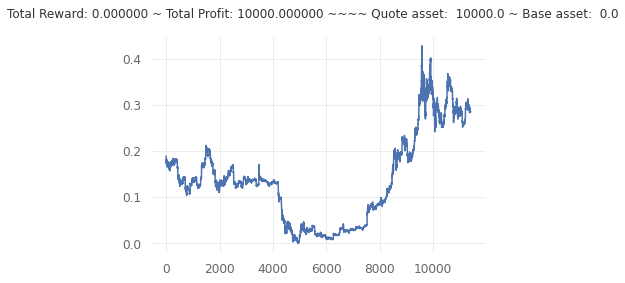

In [168]:
env.render_all()
print(env.trade_history)